#### **Pinn Experiments**

In [1]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # silence Tensorflow and Keras freaking out about a lack
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # of GPU
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set some constants
pi = tf.constant(np.pi, dtype=DTYPE)
viscosity = .01/pi

#### Damped oscillator example

In [3]:
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = tf.math.cos(phi+w*x)
    sin = tf.math.sin(phi+w*x)
    exp = tf.math.exp(-d*x)
    y  = exp*2*A*cos
    return y

Generate training data -- maybe we can encapsulate this into a function or a class.

(500,) (500,)
(10,) (10,)


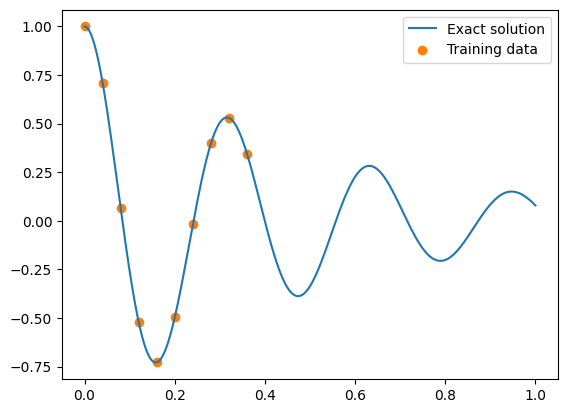

In [4]:
d, w0 = 2, 20

# get the analytical solution over the full domain
x = tf.reshape(tf.linspace(0,1,500), -1, 1)
y = tf.reshape(oscillator(d, w0, x), -1, 1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

#### Pinn_NN and Solver Classes

In [5]:
# Define model architecture -- 
# Python classes adapted from Jan Blechschmidt University of Chemnitz
class PINN_NeuralNet(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,    # lower bound and upper bound
            output_dim=1,
            num_hidden_layers=8, 
            num_neurons_per_layer=20,
            activation='tanh',
            kernel_initializer='glorot_normal',
            **kwargs):
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        self.lb = lb
        self.ub = ub
        
        # Define NN architecture
        self.scale = tf.keras.layers.Lambda(
            lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                             activation=tf.keras.activations.get(activation),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.num_hidden_layers)]
        self.out = tf.keras.layers.Dense(output_dim)
        
    def call(self, X):
        """Forward-pass through neural network."""
        Z = self.scale(X)
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
        return self.out(Z)

In [7]:
import scipy.optimize

class PINNSolver():
    def __init__(self, model, X_r):
        self.model = model
        
        # Store collocation points
        self.t = X_r[:,0:1]
        self.x = X_r[:,1:2]
        
        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0
    
    def get_r(self):
        
        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(self.t)
            tape.watch(self.x)
            
            # Compute current values u(t,x)
            u = self.model(tf.stack([self.t[:,0], self.x[:,0]], axis=1))
            
            u_x = tape.gradient(u, self.x)
            
        u_t = tape.gradient(u, self.t)
        u_xx = tape.gradient(u_x, self.x)
        
        del tape
        
        return self.fun_r(self.t, self.x, u, u_t, u_x, u_xx)
    
    def loss_fn(self, X, u):
        
        # Compute phi_r
        r = self.get_r()
        phi_r = tf.reduce_mean(tf.square(r))
        
        # Initialize loss
        loss = phi_r

        # Add phi_0 and phi_b to the loss
        for i in range(len(X)):
            u_pred = self.model(X[i])
            loss += tf.reduce_mean(tf.square(u[i] - u_pred))
        
        return loss
    
    def get_grad(self, X, u):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn(X, u)
            
        g = tape.gradient(loss, self.model.trainable_variables)
        del tape
        
        return loss, g
    
    def fun_r(self, t, x, u, u_t, u_x, u_xx):
        """Residual of the PDE"""
        return u_t + u * u_x - viscosity * u_xx
    
    def solve_with_TFoptimizer(self, optimizer, X, u, N=1001):
        """This method performs a gradient descent type optimization."""
        
        @tf.function
        def train_step():
            loss, grad_theta = self.get_grad(X, u)
            
            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            return loss
        
        for i in range(N):
            
            loss = train_step()
            
            self.current_loss = loss.numpy()
            self.callback()

    def solve_with_ScipyOptimizer(self, X, u, method='L-BFGS-B', **kwargs):
        """This method provides an interface to solve the learning problem
        using a routine from scipy.optimize.minimize.
        (Tensorflow 1.xx had an interface implemented, which is not longer
        supported in Tensorflow 2.xx.)
        Type conversion is necessary since scipy-routines are written in Fortran
        which requires 64-bit floats instead of 32-bit floats."""
        
        def get_weight_tensor():
            """Function to return current variables of the model
            as 1d tensor as well as corresponding shapes as lists."""
            
            weight_list = []
            shape_list = []
            
            # Loop over all variables, i.e. weight matrices, bias vectors and unknown parameters
            for v in self.model.variables:
                shape_list.append(v.shape)
                weight_list.extend(v.numpy().flatten())
                
            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list

        x0, shape_list = get_weight_tensor()
        
        def set_weight_tensor(weight_list):
            """Function which sets list of weights
            to variables in the model."""
            idx = 0
            for v in self.model.variables:
                vs = v.shape
                
                # Weight matrices
                if len(vs) == 2:  
                    sw = vs[0]*vs[1]
                    new_val = tf.reshape(weight_list[idx:idx+sw],(vs[0],vs[1]))
                    idx += sw
                
                # Bias vectors
                elif len(vs) == 1:
                    new_val = weight_list[idx:idx+vs[0]]
                    idx += vs[0]
                    
                # Variables (in case of parameter identification setting)
                elif len(vs) == 0:
                    new_val = weight_list[idx]
                    idx += 1
                    
                # Assign variables (Casting necessary since scipy requires float64 type)
                v.assign(tf.cast(new_val, DTYPE))
        
        def get_loss_and_grad(w):
            """Function that provides current loss and gradient
            w.r.t the trainable variables as vector. This is mandatory
            for the LBFGS minimizer from scipy."""
            
            # Update weights in model
            set_weight_tensor(w)
            # Determine value of \phi and gradient w.r.t. \theta at w
            loss, grad = self.get_grad(X, u)
            
            # Store current loss for callback function            
            loss = loss.numpy().astype(np.float64)
            self.current_loss = loss            
            
            # Flatten gradient
            grad_flat = []
            for g in grad:
                grad_flat.extend(g.numpy().flatten())
            
            # Gradient list to array
            grad_flat = np.array(grad_flat,dtype=np.float64)
            
            # Return value and gradient of \phi as tuple
            return loss, grad_flat
        
        
        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)
        
    def callback(self, xr=None):
        if self.iter % 50 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(self.iter,self.current_loss))
        self.hist.append(self.current_loss)
        self.iter+=1
        
    
    def plot_solution(self, **kwargs):
        N = 600
        tspace = np.linspace(self.model.lb[0], self.model.ub[0], N+1)
        xspace = np.linspace(self.model.lb[1], self.model.ub[1], N+1)
        T, X = np.meshgrid(tspace, xspace)
        Xgrid = np.vstack([T.flatten(),X.flatten()]).T
        upred = self.model(tf.cast(Xgrid,DTYPE))
        U = upred.numpy().reshape(N+1,N+1)
        fig = plt.figure(figsize=(9,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(T, X, U, cmap='viridis', **kwargs)
        ax.set_xlabel('$t$')
        ax.set_ylabel('$x$')
        ax.set_zlabel('$u_\\theta(t,x)$')
        ax.view_init(35,35)
        return ax
        
    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7,5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist,'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

#### Initialize model with simple Oscillator Eq.

In [ ]:
# Initialize model
model = PINN_NeuralNet(lb, ub)
model.build(input_shape=(None,2))

# Initilize PINN solver
solver = PINNSolver(model, X_r)

# Decide which optimizer should be used
#mode = 'TFoptimizer'
mode = 'ScipyOptimizer'

# Start timer
t0 = time()

if mode == 'TFoptimizer':
    # Choose optimizer
    lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])
    optim = tf.keras.optimizers.Adam(learning_rate=lr)            # Seems strange given ADAM incorporates a learning rate decay
    solver.solve_with_TFoptimizer(optim, X_data, u_data, N=4001)  # by default
    
elif mode == 'ScipyOptimizer':
    solver.solve_with_ScipyOptimizer(X_data, u_data,
                            method='L-BFGS-B',
                            options={'maxiter': 50000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1.0*np.finfo(float).eps})

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))